In [158]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# numpy produces many warnings, we don't need them here
np.warnings.filterwarnings('ignore')

# define commonly used colors
BLACK, PURPLE = 'black', 'purple'
BLUE, ORANGE, BLUE1 = 'dodgerblue', 'orange', '#174A7E'

# configure all plots font family and border line widths
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 0.5

In [159]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
import pandas as pd

In [160]:
df = pd.read_csv("mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

# set the known BLUE and ORANGE clusters means
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])
all_means = np.vstack((blue_means, orange_means))

In [161]:
# even though we already know means and covariances, we need to
# do "fake fit", otherwise GaussianMixture model will not work
gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)
# set known covariances
gaussian_mixture_model.covariances_ = [1/5]*20
# it looks like a hack, but GaussianMixture uses precisions_cholesky_
# for predict_proba method. Because we changed covariances_ we need
# to recalculate precisions_cholesky_ too.
gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

In [162]:
# sample 10,000 points for testing
X_test, y_test = gaussian_mixture_model.sample(10000)
# y_test contains sampled component indices
# index < 10 means that the class is BLUE (0)
y_test = 1*(y_test >= 10)

In [163]:
def optimal_bayes_predict(X):
    components_proba = gaussian_mixture_model.predict_proba(X)
    # first 10 components are BLUE(0), and others are BROWN(1)
    blue_proba = np.sum(components_proba[:, :10], axis=1)
    brown_proba = np.sum(components_proba[:, 10:], axis=1)
    y_hat = 1*(blue_proba < brown_proba)
    return y_hat

In [164]:
bayes_error_rate = 1 - accuracy_score(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2148


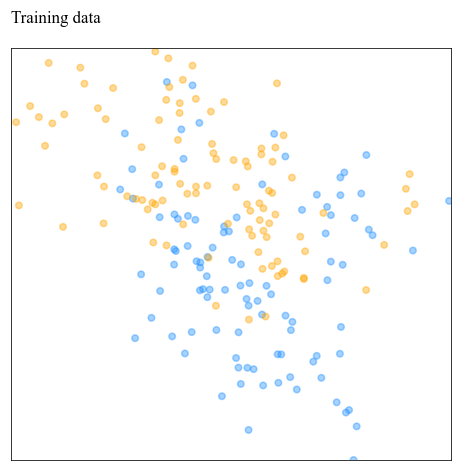

In [165]:
# prepares a plot with a title and circles representing training data
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=110)
    ax.set_aspect(1.3)
    ax.scatter(X_train[:, 0], X_train[:, 1], s=18, alpha = 0.4, color=np.array([BLUE, ORANGE])[y_train])
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-2.6, 4.2)
    ax.set_ylim(-2.0, 2.9)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-2.6, 3.2, title, color=BLACK, fontsize=11)
    for spine in ax.spines.values():
        spine.set_color(BLACK)
    return fig, ax

# test it
_, _ = plot_train_data('Training data')

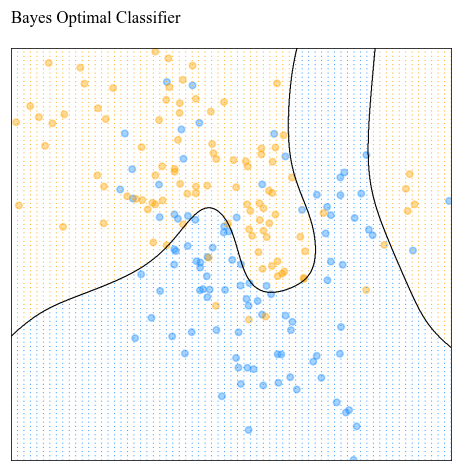

In [166]:
# given a model prediction function computes X points on n x n grid and the
# corresponding predicted classes
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-2.6, 4.2, n1), np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X)
    return X, y


# given a model prediction function computes X0 and X1 n x n meshgrids
# and the corresponing predicted classes meshgrid
def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[:, 0].reshape(n1, n2), X[:, 1].reshape(n1, n2), y.reshape(n1, n2)


# given a model prediction function plots train data, model decision
# bounary and background dots
def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X[:, 0], X[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=BLACK, linewidths=[0.7])
    return fig, ax

# plot the optimal Bayes decision boundary
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

In [167]:
# lets save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = fill_prediction_meshgrid(optimal_bayes_predict)


# given a model prediction function plots performance statistics
def plot_model_stat(predict, title):
    fig, ax = plot_model(predict, title)
    ax.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple',
               linewidths=[0.5], linestyles='dashed')
    test_error_rate = 1 - accuracy_score(y_test, predict(X_test))
    train_error_rate = 1 - accuracy_score(y_train, predict(X_train))
    parms = {'color': BLACK, 'fontsize': 10,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
    ax.text(-2.45, -1.37, f'Training Error: {train_error_rate:.3f}', **parms)
    ax.text(-2.45, -1.64, f'Test Error:       {test_error_rate:.3f}', **parms)
    ax.text(-2.45, -1.91, f'Bayes Error:    {bayes_error_rate:.3f}', **parms)
    return fig, ax

In [168]:
from sklearn.linear_model import LinearRegression

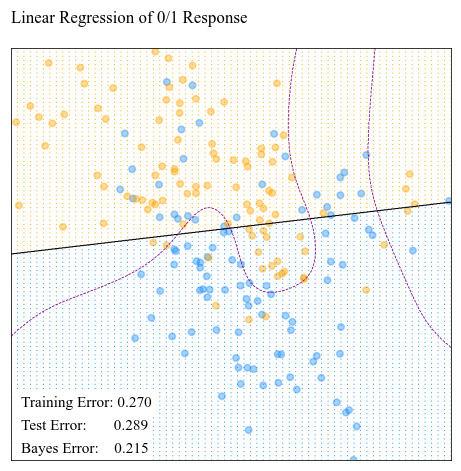

In [169]:
# PAGE 12. Let’s look at an example of the linear model in a classiﬁcation
#          context.
linear_regression_model = LinearRegression().fit(X_train, y_train)


# PAGE 12. The fitted values Y-hat are converted to a fitted class variable
#          G-hat according to the rule G-hat = (ORANGE if Y-hat > 0.5, BLUE if
#          Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(linear_regression_model.predict(X) > 0.5)

# PAGE 13. The line is the decision boundary defined by x.T @ b = 0.5. The
#          orange shaded region denotes that part of input space classified as
#          ORANGE, while the blue region is classified as BLUE.
_, _ = plot_model_stat(linear_predict, 'Linear Regression of 0/1 Response')

In [170]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [171]:
# Run GridSearchCV to find the best n_neighbors parameter using the 10-folds
# CV. It finds 12, but the book uses 15-Nearest Neighbor Classifier because
# the authors selected the most parsimonious model within one standard error
# from the best model (one standard error rule). We will apply this rule in
# other examples, not here.
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': list(range(1, 100))},
    cv=10
).fit(X_train, y_train)
print(k_neighbors_grid_search.best_params_)

{'n_neighbors': 12}


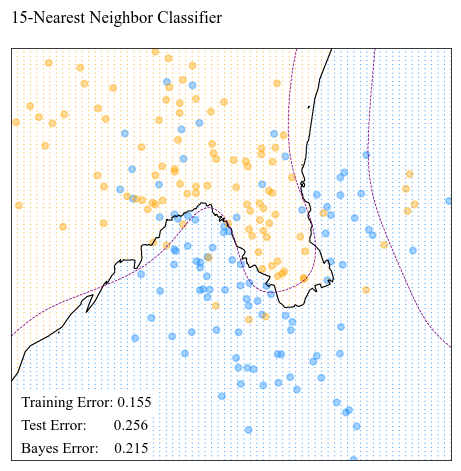

In [172]:
# PAGE 14. Use 15-nearest-neighbor averaging of the binary coded response as
#          the method of fitting. Thus Y-hat is the proportion of ORANGE’s in
#          the neighborhood, and so assigning class ORANGE to G-hat if
#          Y-hat>0.5 amounts to a majority vote in the neighborhood.
neighbors15_classifier = KNeighborsClassifier(
    n_neighbors=15
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors15_classifier.predict, '15-Nearest Neighbor Classifier')

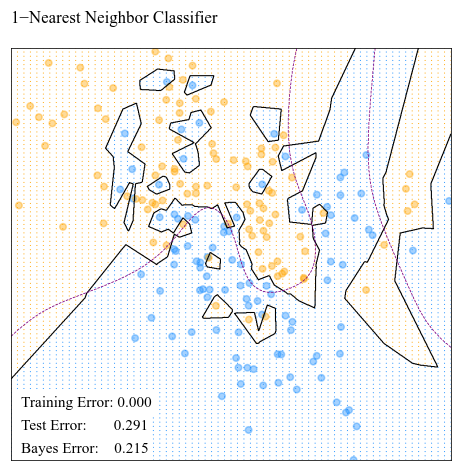

In [173]:
# PAGE 16. The classes are coded as a binary variable (BLUE = 0,ORANGE = 1),
#          and then predicted by 1-nearest-neighbor classiﬁcation.
neighbors1_classifier = KNeighborsClassifier(
    n_neighbors=1
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors1_classifier.predict, '1−Nearest Neighbor Classifier')

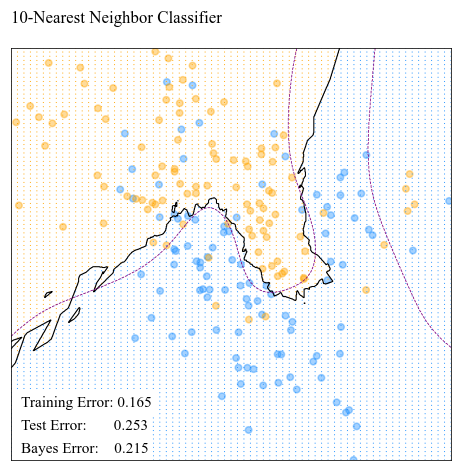

In [174]:
# Use 12-nearest-neighbor averaging of the binary coded response as
neighbors12_classifier = KNeighborsClassifier(
    n_neighbors=12
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors12_classifier.predict, '10-Nearest Neighbor Classifier')

In [175]:
n_neighbors_vals = list(range(1, 20)) + list(range(20, 101, 5))
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': n_neighbors_vals},
    cv=10, scoring='accuracy',
    return_train_score=True, iid=True
).fit(X_train, y_train)
print(k_neighbors_grid_search.best_params_)

train_errors, test_errors = [], []
for k in n_neighbors_vals:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

{'n_neighbors': 12}


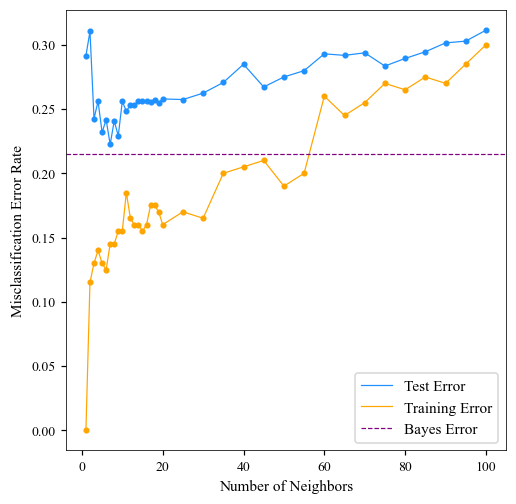

In [176]:
# PAGE 467. k-nearest-neighbors on the two-class mixture data. The upper
#           panel shows the misclassification errors as a function of
#           neighborhood size. Standard error bars are included for 10-fold
#           cross validation. The lower panel shows the decision boundary
#           for 7-nearest-neighbors, which appears to be optimal for minimizing
#           test error.

fig, ax = plt.subplots(figsize=(4, 4), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(n_neighbors_vals, test_errors, c=BLUE, s=9)
ax.plot(n_neighbors_vals, test_errors, c=BLUE, linewidth=0.8,
        label='Test Error')
ax.scatter(n_neighbors_vals, train_errors, c=ORANGE, s=9)
ax.plot(n_neighbors_vals, train_errors, c=ORANGE, linewidth=0.8,
        label='Training Error')

ax.axhline(y=bayes_error_rate, c=PURPLE, linewidth=0.8, linestyle='--',
           label='Bayes Error')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(9)
ax.set_xlabel('Number of Neighbors', color=BLACK, fontsize=10)
ax.set_ylabel('Misclassification Error Rate', color=BLACK, fontsize=10)
_ = ax.legend(loc='lower right', prop={'size': 10})